In [ ]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.3 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
!wget https://hips.hearstapps.com/ghk.h-cdn.co/assets/17/30/pembroke-welsh-corgi.jpg -O "dog_1.jpg"
model=YOLO("yolov8n.pt",)


In [ ]:
result = model.predict(source="dog_1.jpg")

In [ ]:
result

In [ ]:
cls_id  = result[0].boxes.cls[0].item()
cls_conf  = result[0].boxes.conf[0].item()
cls_id,cls_conf

(16.0, 0.9029132723808289)

In [ ]:
bbox=result[0].boxes.data[0][:-2]

In [ ]:
all_cls =result[0].names

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-08-19 17:12:23--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.39.25, 13.249.39.6, 13.249.39.82, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.39.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   130MB/s    in 15s     

2023-08-19 17:12:38 (161 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
bbox

tensor([ 352.9602,  416.2450,  982.2102, 1517.6892])

In [ ]:
imarr  = cv2.imread("dog_1.jpg")
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.rectangle(imarr,(355,416),(982,1517),(0,0,0),1))

In [ ]:
crop_arr = imarr[416:1517,355:982,:]

In [ ]:
input_point = np.array([[(982 +355)/2,(1517 +416)/2]])
input_label = np.array([1])

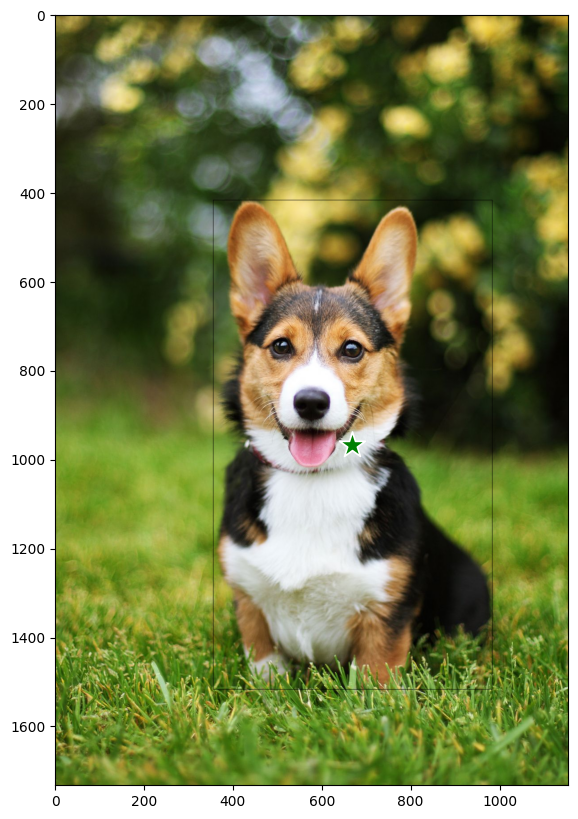

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(imarr,cv2.COLOR_BGR2RGB))
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
predictor.set_image(imarr)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(imarr)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

## method 2

In [ ]:
input_point = np.array([[(982 - 355)/2,(1517 - 416)/2]])
input_label = np.array([1])

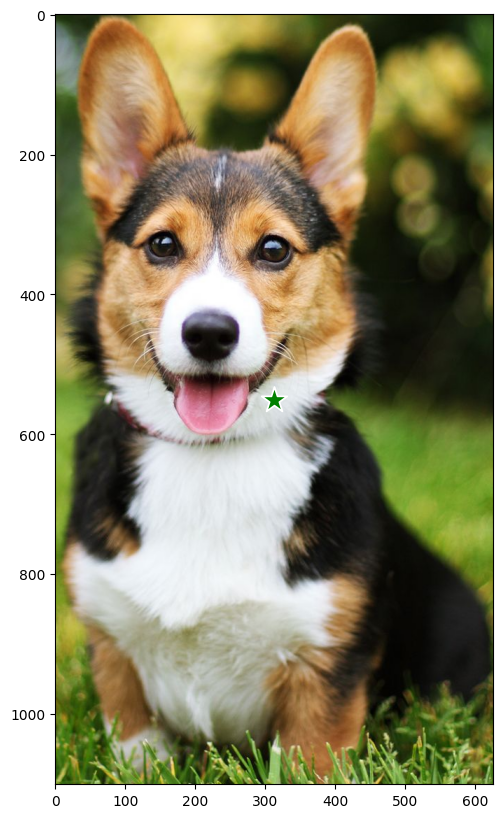

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(crop_arr,cv2.COLOR_BGR2RGB))
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
predictor.set_image(crop_arr)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(crop_arr)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

True